In [63]:
# !pip install catboost

In [64]:
# !pip install ml_metrics

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

In [48]:
merged = pd.read_csv('data/merged_data.csv', index_col=None)
merged.head()

D:\programs\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (11,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Unnamed: 0,order_id,user_id,line_item_id,price,quantity,discount,product_id,brand_name,master_category_id,parent_category_id,order_created_time,retailer,platform,city_name,gender,bdate,age
0,0,139128,1050,97633689,236.89,1,0.0,5045454,3573,122,119,-1,-1,-1,-1,-1,-1,-1
1,1,139128,1050,97633791,178.16,1,0.0,73719,5154,122,119,-1,-1,-1,-1,-1,-1,-1
2,2,139128,1050,97635201,173.28,1,0.0,7000939,2846,85,84,-1,-1,-1,-1,-1,-1,-1
3,3,139128,1050,97635312,73.69,1,0.0,7386015,3342,85,84,-1,-1,-1,-1,-1,-1,-1
4,4,139128,1050,97635414,282.14,1,0.0,73291,2846,85,84,-1,-1,-1,-1,-1,-1,-1


In [49]:
print(merged['user_id'].nunique())
print(merged['product_id'].nunique())
print(len(merged))

merged = merged[merged['product_id'] != 0]
print(len(merged))

107068
91994
21677070
21466723


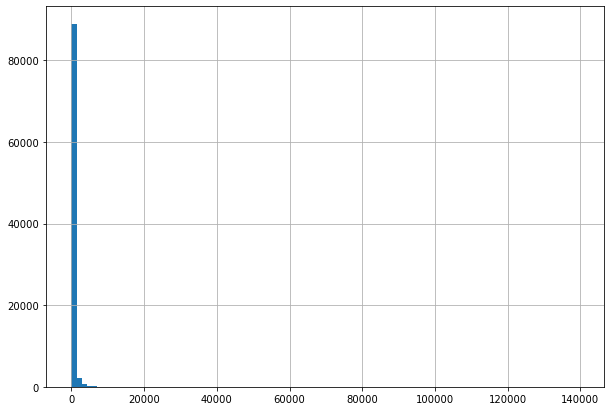

In [50]:
plt.figure(figsize=(10, 7))
merged['product_id'].value_counts().hist(bins=100)

In [51]:
merged['user_id'].nunique()

107066

In [52]:
groupby_0 = pd.DataFrame({'count' : merged.groupby(['product_id']).size()}).reset_index()
groupby_0 = groupby_0.sort_values(['count'], ascending=False)
groupby_0.head(3)

,product_id,count
193,709,139570
9290,39590,44804
71,166,36970


In [53]:
groupby_0['count'].sum()

21466723

In [54]:
# доля покрытия
groupby_0[:1000]['count'].sum() / groupby_0['count'].sum()

0.28358841729126516

In [55]:
# доля покрытия
groupby_0[:15000]['count'].sum() / groupby_0['count'].sum()

0.8288523124838384

In [56]:
# доля покрытия
groupby_0[:35000]['count'].sum() / groupby_0['count'].sum()

0.9561352238066332

In [57]:
# фильтруем по продуктам
top_products = groupby_0[:15000]['product_id'].tolist()

merged = merged[merged['product_id'].isin(top_products)]
print(len(merged))
print(merged['user_id'].nunique())

MemoryError: Unable to allocate 1.86 GiB for an array with shape (14, 17792743) and data type int64

In [ ]:
users_n_orders = merged.groupby(['user_id'])['order_id'].nunique().to_frame('count').reset_index()
users_n_orders.head(3)

In [ ]:
valid_users = users_n_orders[users_n_orders['count'] >= 2]
valid_users_ids = valid_users['user_id'].tolist()
print('valid_users_ids', len(valid_users_ids))

merged = merged[merged['user_id'].isin(valid_users_ids)]
print(len(merged))

In [ ]:
merged_ = merged[merged['order_created_time'].values != -1]
merged_ = merged_[merged_['order_created_time'].values != '-1']
merged_ = merged_.drop(columns=['Unnamed: 0']) 

# Change data types to reduce memory footprint
merged_ = merged_.astype({
    'user_id': 'int32',
    'order_id': 'int32',
    'price': 'float32',
    'quantity': 'int32',
    'discount': 'float32',
    'product_id': 'int32',
    'brand_name': 'int32',
    'master_category_id': 'int32',
    'parent_category_id': 'int32',
    'order_created_time': str,
    'retailer': 'int32',
    'platform': 'int32',
    'city_name': 'int32',
    'gender': 'int32',
    'age': 'int32'}, copy=False)

merged_['order_created_time'] = pd.to_datetime(merged_['order_created_time'], format='%Y-%m-%d %H:%M:%S', exact=True)

In [ ]:
merged_.dtypes

In [ ]:
merged_.head(3)

In [ ]:
last_order = merged_.groupby(['user_id'])['order_created_time'].max().to_frame('order_created_time').reset_index()
last_order.head(3)

In [ ]:
target = pd.merge(merged_, last_order, on=['user_id', 'order_created_time']) 
print(len(target))

target_user_product_pos = target[['user_id', 'product_id']]
target_user_product_pos['target'] = 1
target_user_product_pos = target_user_product_pos.drop_duplicates()
target_user_product_pos.head(3)

In [ ]:
# # коряво
last_order['user_date'] = last_order['user_id'].apply(str) + last_order['order_created_time'].apply(str)
merged_['user_date'] = merged_['user_id'].apply(str) + merged_['order_created_time'].apply(str)

merged_ = merged_[~merged_['user_date'].isin(set(last_order['user_date']))]
len(merged_)

In [ ]:
del merged

In [ ]:
merged_.head(3)

In [22]:
features = merged_.groupby(['user_id', 'product_id', 'master_category_id', 
                            'parent_category_id']).agg(
    product_count=pd.NamedAgg(column='order_created_time', aggfunc='count'),
    avg_discount=pd.NamedAgg(column='discount', aggfunc='mean'),
    max_discount=pd.NamedAgg(column='discount', aggfunc='max'),
    min_discount=pd.NamedAgg(column='discount', aggfunc='min'),
    avg_price=pd.NamedAgg(column='price', aggfunc='mean'),
    max_price=pd.NamedAgg(column='price', aggfunc='max'),
    min_price=pd.NamedAgg(column='price', aggfunc='min'),
#     max_date=pd.NamedAgg(column='order_created_time', aggfunc='max')
).reset_index()
            
features.head(3)

,user_id,product_id,master_category_id,parent_category_id,product_count,avg_discount,max_discount,min_discount,avg_price,max_price,min_price
0,400,41,85,84,1,0.0,0.0,0.0,59.000000,59.000000,59.000000
1,400,177,26,20,1,0.0,0.0,0.0,74.889999,74.889999,74.889999
2,400,397,38,35,1,139.0,139.0,139.0,265.000000,265.000000,265.000000


In [23]:
train = pd.merge(features, target_user_product_pos, on=['user_id', 'product_id'], how='outer')
train['target'] = train['target'].fillna(0)
print(train['target'].value_counts())
print(train['target'].value_counts(normalize=True))
train.head(3)

0.0    9682585
1.0    1629580
Name: target, dtype: int64
0.0    0.855944
1.0    0.144056
Name: target, dtype: float64


,user_id,product_id,master_category_id,parent_category_id,product_count,avg_discount,max_discount,min_discount,avg_price,max_price,min_price,target
0,400,41,85.0,84.0,1.0,0.0,0.0,0.0,59.000000,59.000000,59.000000,0.0
1,400,177,26.0,20.0,1.0,0.0,0.0,0.0,74.889999,74.889999,74.889999,1.0
2,400,397,38.0,35.0,1.0,139.0,139.0,139.0,265.000000,265.000000,265.000000,0.0


In [24]:
len(target_user_product_pos)

1629580

In [25]:
len(features)

10197053

In [26]:
len(train)

11312165

In [27]:
sum(features[['user_id', 'product_id']].groupby('user_id').product_id.nunique())

10197053

In [28]:
sum(target_user_product_pos[['user_id', 'product_id']].groupby('user_id').product_id.nunique())

1629580

In [29]:
# add user properities
# users_info = merged_.groupby(['user_id']).agg(
#     orders_count=pd.NamedAgg(column='order_id', aggfunc='count'),
# ).reset_index()

# train = pd.merge(train, user_info, on='user_id')
# train['purchase_share'] = train['product_count'] / train['orders_count']

In [30]:
# product properities
products = merged_.groupby(['product_id', 'master_category_id', 'parent_category_id']).agg(
    avg_discount=pd.NamedAgg(column='discount', aggfunc='mean'),
    max_discount=pd.NamedAgg(column='discount', aggfunc='max'),
    min_discount=pd.NamedAgg(column='discount', aggfunc='min'),
    avg_price=pd.NamedAgg(column='price', aggfunc='mean'),
    max_price=pd.NamedAgg(column='price', aggfunc='max'),
    min_price=pd.NamedAgg(column='price', aggfunc='min'),
).reset_index()

products.head(3)

,product_id,master_category_id,parent_category_id,avg_discount,max_discount,min_discount,avg_price,max_price,min_price
0,8,22,20,8.530293,17.389999,0.0,46.236069,61.599998,37.799999
1,11,22,20,2.334837,49.099998,0.0,110.383926,132.690002,70.900002
2,22,22,20,3.927326,25.040001,0.0,56.427719,72.650002,39.950001


In [31]:
train['master_category_id'].isnull().any()

True

In [32]:
train_pos_but_nf = train[train['master_category_id'].isnull()]
train_pos_but_nf = train_pos_but_nf[['user_id', 'product_id']]
train_pos_but_nf.head(3)

,user_id,product_id
10197053,684753,55134
10197054,684753,26751
10197055,684753,14681


In [33]:
train_pos_but_nf = pd.merge(train_pos_but_nf, products, on=['product_id'])
train_pos_but_nf['target'] = 1
train_pos_but_nf['product_count'] = 0
train_pos_but_nf.head(3)

,user_id,product_id,master_category_id,parent_category_id,avg_discount,max_discount,min_discount,avg_price,max_price,min_price,target,product_count
0,684753,55134,85,84,14.239791,100.0,0.0,110.975288,1617.27002,0.0,1,0
1,255316,55134,85,84,14.239791,100.0,0.0,110.975288,1617.27002,0.0,1,0
2,714884,55134,85,84,14.239791,100.0,0.0,110.975288,1617.27002,0.0,1,0


In [34]:
train_final = train[~train['master_category_id'].isnull()].append(train_pos_but_nf)

In [35]:
train_final['master_category_id'].isnull().any()

False

In [36]:
len(train_final)

11312165

In [37]:
len(train)

11312165

In [38]:
train_final = train_final.sort_values('user_id')

In [39]:
train_final.head(5)

,user_id,product_id,master_category_id,parent_category_id,product_count,avg_discount,max_discount,min_discount,avg_price,max_price,min_price,target
0,400,41,85.0,84.0,1.0,0.0,0.0,0.0,59.000000,59.000000,59.000000,0.0
74,400,5044752,643.0,99.0,1.0,0.0,0.0,0.0,190.000000,190.000000,190.000000,0.0
73,400,4830932,85.0,84.0,1.0,80.0,80.0,80.0,170.289993,170.289993,170.289993,0.0
72,400,4203260,638.0,84.0,1.0,0.0,0.0,0.0,144.000000,144.000000,144.000000,1.0
71,400,4141821,30.0,20.0,1.0,0.0,0.0,0.0,51.290001,51.290001,51.290001,0.0


In [40]:
train_final['target'].isnull().any()

False

In [41]:
train_final['parent_category_id'].isnull().any()

False

In [42]:
train_final['product_count'].isnull().any()

False

### Модель


In [31]:
import ml_metrics as metrics
from catboost import CatBoost, CatBoostClassifier, Pool

In [44]:
train_final = train_final.astype({
    'master_category_id' : 'int32', 
    'parent_category_id' : 'int32',
    'target' : 'int32',
    'product_count' : 'int32',
    'user_id' : 'int32',
    'product_id' : 'int32',
})

train_final.dtypes

user_id                 int32
product_id              int32
master_category_id      int32
parent_category_id      int32
product_count           int32
avg_discount          float32
max_discount          float32
min_discount          float32
avg_price             float32
max_price             float32
min_price             float32
target                  int32
dtype: object

In [45]:
train_final['GroupId'] = train_final['user_id'].apply(str)

# train_labels = train['target']
# train = train.drop(columns=['target'])

print(len(set(train_final['GroupId'])))
train_final.head(3)

84144


,user_id,product_id,master_category_id,parent_category_id,product_count,avg_discount,max_discount,min_discount,avg_price,max_price,min_price,target,GroupId
0,400,41,85,84,1,0.0,0.0,0.0,59.000000,59.000000,59.000000,0,400
74,400,5044752,643,99,1,0.0,0.0,0.0,190.000000,190.000000,190.000000,0,400
73,400,4830932,85,84,1,80.0,80.0,80.0,170.289993,170.289993,170.289993,0,400


### ДАЛЬШЕ НЕ ЧИТАТЬ ЭТО АППЕНДИКС))))

In [36]:
def calculate_mapk(predictions, test=True):
    if test:
        res = train.iloc[train_size: train_size + test_size]
    else:
        res = train.iloc[:train_size]
    
    res.loc[:, 'pred'] = predictions
    res = res.sort_values(['user_id', 'pred'], ascending=False)

    predicted_lists = res.groupby('user_id')['product_id'].apply(list)

    if test:
        actual_lists = res[train_labels.iloc[train_size: train_size + test_size] == 1].groupby('user_id')['product_id'].apply(list)
        actual_lists = [l[:50] for l in actual_lists.tolist()] 
    else:
        actual_lists = res[train_labels.iloc[:train_size] == 1].groupby('user_id')['product_id'].apply(list)
        actual_lists = [l[:50] for l in actual_lists.tolist()] 

    return metrics.mapk(actual_lists, predicted_lists.tolist(), 50)
    

In [37]:
%%time
param = {
    'iterations': 50, 
    'task_type': 'CPU', 
    'loss_function': 'YetiRank',
    'cat_features': ['master_category_id', 'parent_category_id', 'product_id'],
}
model = CatBoost(param)
train_size = int(len(train) * 0.1)
test_size = int(len(train) * 0.1)
train_pool = Pool(
    data=train.iloc[:train_size], 
    label=train_labels.iloc[:train_size], 
    group_id=train.iloc[:train_size]['GroupId'],
    cat_features=['master_category_id', 'parent_category_id', 'product_id'],
)
test_pool = Pool(
    data=train.iloc[train_size: train_size + test_size], 
    label=train_labels.iloc[train_size: train_size + test_size], 
    group_id=train.iloc[train_size: train_size + test_size]['GroupId'],
    cat_features=['master_category_id', 'parent_category_id', 'product_id'],
)
model.fit(train_pool, verbose=0, plot=True)

from sklearn.metrics import roc_auc_score

predictions = model.predict(train_pool)
print('train auc', roc_auc_score(train_pool.get_label(), predictions))
print('train MAP@k', calculate_mapk(predictions, False))

predictions = model.predict(test_pool)
print('test auc', roc_auc_score(test_pool.get_label(), predictions))
print('test MAP@k', calculate_mapk(predictions, True))

CatBoostError: Invalid type for cat_feature[non-default value idx=0,feature_idx=2]=85.0 : cat_features must be integer or string, real number values and NaN values should be converted to string.

In [71]:
importances = model.get_feature_importance(train_pool)

In [78]:
for name, importance in sorted(zip(model.feature_names_, importances), key=lambda x: x[1], reverse=True):
    # print("%s, %.8f" % (f, importances[i]))
    print(f'{name}, {importance:.8f}')

product_count, 0.02632665
product_id, 0.01084888
max_discount, 0.00086650
master_category_id, 0.00029641
avg_discount, 0.00009950
min_discount, 0.00004216
min_price, 0.00002497
max_price, 0.00000603
user_id, 0.00000000
avg_price, 0.00000000
GroupId, 0.00000000
parent_category_id, -0.00007575


### Submit

In [ ]:
%%time
param = {
    'iterations': 50, 
    'task_type': 'CPU', 
    'loss_function': 'YetiRank',
    'cat_features': ['master_category_id', 'parent_category_id', 'product_id'],
}
model_2 = CatBoost(param)
train_size = len(train)
# test_size = int(len(train) * 0.3)
train_pool = Pool(
    data=train.iloc[:train_size], 
    label=train_labels.iloc[:train_size], 
    group_id=train.iloc[:train_size]['GroupId'],
    cat_features=['master_category_id', 'parent_category_id', 'product_id'],
)
# test_pool = Pool(
#     data=train.iloc[train_size: train_size + test_size], 
#     label=train_labels.iloc[train_size: train_size + test_size], 
#     group_id=train.iloc[train_size: train_size + test_size]['GroupId'],
#     cat_features=['master_category_id', 'parent_category_id', 'product_id'],
# )
model_2.fit(train_pool, verbose=0, plot=True)

from sklearn.metrics import roc_auc_score

predictions = model_2.predict(train_pool)
print('train auc', roc_auc_score(train_pool.get_label(), predictions))
print('train MAP@k', calculate_mapk(predictions, False))

# predictions = model_2.predict(test_pool)
# print('test auc', roc_auc_score(test_pool.get_label(), predictions))
# print('test MAP@k', calculate_mapk(predictions, True))

In [ ]:
#